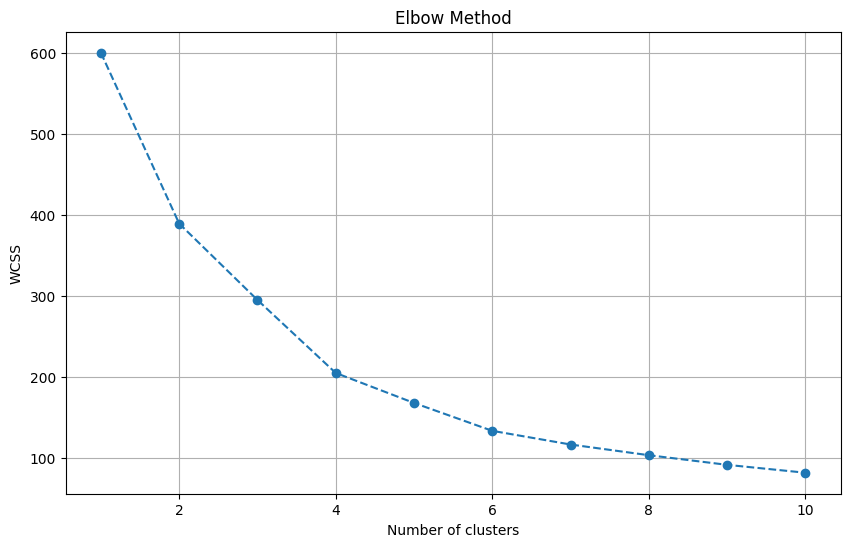

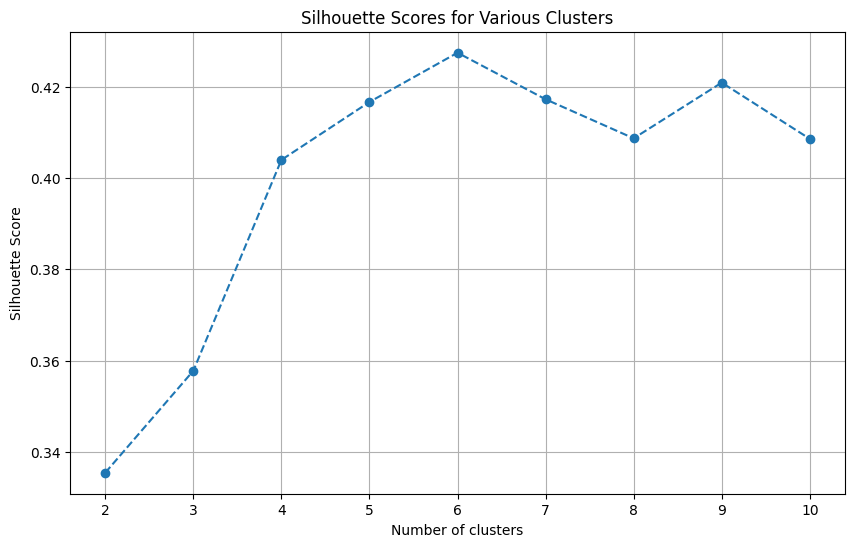

In [5]:
#CUSTOMER SEGMENTATION ANALYSIS USING K MEANS CLUSTERING METHOD

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the dataset
data = pd.read_csv('/Users/yash/Downloads/Mall_Customers.csv')

# Select features
X = data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method for finding the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# Silhouette Score Evaluation through the Number of Clusters
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Scores for Various Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


Optimal number of components: 3


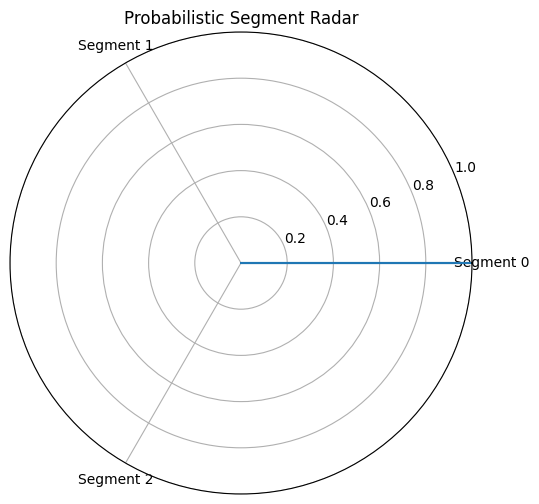

In [6]:
#CUSTOMER SEGMENTATION ANALYSIS USING GMM

import os
os.environ['OMP_NUM_THREADS'] = '1'  # Set the number of threads to 1

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Load and preprocess the data
def load_and_preprocess_data(file_path):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Convert the 'Annual Income' and 'Spending Score' columns to floats
    df['Annual Income (k$)'] = df['Annual Income (k$)'].astype(float)
    df['Spending Score (1-100)'] = df['Spending Score (1-100)'].astype(float)
    
    # One-hot encode the 'Gender' column
    df = pd.get_dummies(df, columns=['Gender'])
    
    # Drop the 'CustomerID' column and use the remaining columns as features
    features = df.drop(columns=['CustomerID'])
    
    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)
    
    return X_scaled, features.columns

# 2. Implement Gaussian Mixture Model (GMM)
def implement_gmm(X, n_components_range=range(1, 10)):
    bic_scores = []  # Store BIC scores for each model
    
    # Fit GMM models with different numbers of components and store their BIC scores
    for n in n_components_range:
        gmm = GaussianMixture(n_components=n, random_state=42)
        gmm.fit(X)
        bic_scores.append(gmm.bic(X))
    
    # Determine the optimal number of components (based on the lowest BIC)
    optimal_n = n_components_range[np.argmin(bic_scores)]
    
    # Fit the final GMM model using the optimal number of components
    gmm = GaussianMixture(n_components=optimal_n, random_state=42)
    gmm.fit(X)
    
    return gmm, optimal_n

# 3. Create a radar chart for probabilistic segment visualization
def probabilistic_segment_radar(gmm, X, instance_index):
    # Get the probabilities for each segment for a specific instance
    probabilities = gmm.predict_proba(X[instance_index].reshape(1, -1))[0]
    
    # Create angles for the radar chart
    angles = np.linspace(0, 2 * np.pi, len(probabilities), endpoint=False)
    
    # Close the radar chart loop
    probabilities = np.concatenate((probabilities, [probabilities[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    
    # Plot the radar chart
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='polar'))
    ax.plot(angles, probabilities)
    ax.fill(angles, probabilities, alpha=0.25)
    
    # Set segment labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([f"Segment {i}" for i in range(len(probabilities) - 1)])
    
    # Set the y-axis limit
    ax.set_ylim(0, 1)
    
    # Add a title to the plot
    plt.title("Probabilistic Segment Radar")
    plt.show()

# Main script
if __name__ == "__main__":
    # Specify the file path to the dataset
    file_path = '/Users/yash/Downloads/Mall_Customers.csv'
    
    # Load and preprocess the data
    X, feature_names = load_and_preprocess_data(file_path)
    
    # Split the dataset into training and testing sets
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
    
    # Implement GMM and determine the optimal number of components
    gmm, optimal_n = implement_gmm(X_train)
    
    # Print the optimal number of components
    print(f"Optimal number of components: {optimal_n}")
    
    # Get the probabilistic segment assignments for the test set
    probabilities = gmm.predict_proba(X_test)
    
    # Visualize the probabilistic segment for a specific test instance
    instance_index = 0
    probabilistic_segment_radar(gmm, X_test, instance_index)

Optimal number of components: 3


  0%|          | 0/40 [00:00<?, ?it/s]

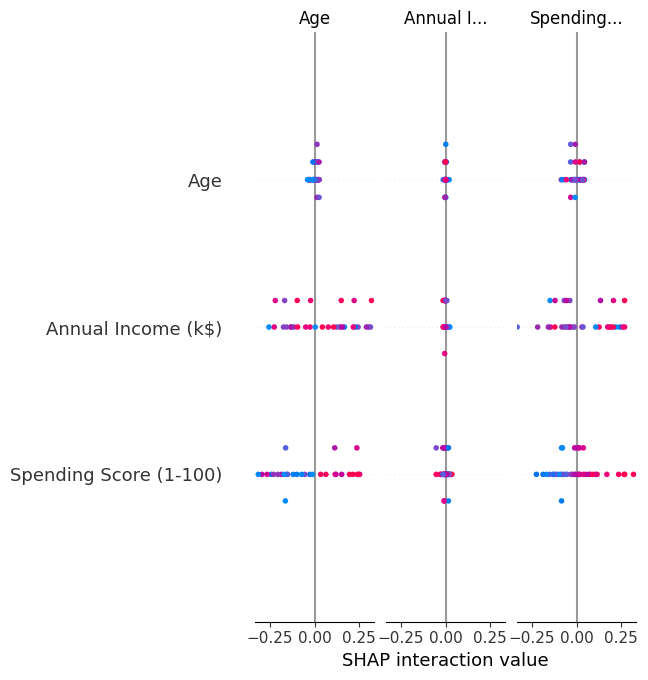

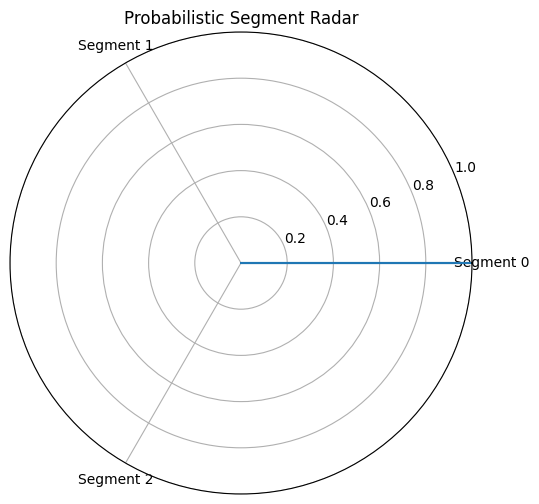

In [8]:
#CUSTOMER SEGMENTATION ANALYSIS USING GMM WITH XAI

import os
os.environ['OMP_NUM_THREADS'] = '1'

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and Prepare the Data
def load_and_preprocess_data(file_path):
    # Load the dataset
    data = pd.read_csv(file_path)
    
    # Ensure numerical consistency
    data['Annual Income (k$)'] = data['Annual Income (k$)'].astype(float)
    data['Spending Score (1-100)'] = data['Spending Score (1-100)'].astype(float)
    
    # Convert categorical variables to numerical ones
    data = pd.get_dummies(data, columns=['Gender'])
    
    # Drop non-essential columns and prepare features
    features = data.drop(columns=['CustomerID'])
    
    # Normalize the features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)
    
    return normalized_features, features.columns

# Step 2: Gaussian Mixture Model (GMM) Implementation
def implement_gmm(X, n_components_range=range(1, 10)):  # Considering a smaller range
    bic_scores = []
    
    # Evaluate GMM for different numbers of components
    for n_components in n_components_range:
        gmm_model = GaussianMixture(n_components=n_components, random_state=42)
        gmm_model.fit(X)
        bic_scores.append(gmm_model.bic(X))
    
    # Determine the optimal number of components based on BIC
    optimal_components = n_components_range[np.argmin(bic_scores)]
    
    # Train the GMM with the optimal number of components
    best_gmm_model = GaussianMixture(n_components=optimal_components, random_state=42)
    best_gmm_model.fit(X)
    
    return best_gmm_model, optimal_components

# Step 3: Explainability Techniques (XAI)
def apply_shap(gmm_model, X, feature_names):
    from sklearn.linear_model import LogisticRegression
    
    # Train a surrogate model for SHAP
    surrogate = LogisticRegression(max_iter=1000)
    surrogate.fit(X, gmm_model.predict(X))
    
    # Use a subset of the data to calculate SHAP values
    shap_explainer = shap.KernelExplainer(surrogate.predict_proba, shap.sample(X, 100))
    shap_values = shap_explainer.shap_values(X)
    
    # Visualize the feature importance
    shap.summary_plot(shap_values, X, plot_type="bar", feature_names=feature_names)

def apply_lime(gmm_model, X, feature_names, instance_index):
    from sklearn.linear_model import LogisticRegression
    
    # Train a surrogate model for LIME
    surrogate = LogisticRegression(max_iter=1000)
    surrogate.fit(X, gmm_model.predict(X))
    
    # Create a LIME explainer
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X, feature_names=feature_names, class_names=[f"Segment {i}" for i in range(gmm_model.n_components)],
        mode="classification"
    )
    
    # Explain a single instance
    explanation = lime_explainer.explain_instance(X[instance_index], surrogate.predict_proba)
    explanation.show_in_notebook(show_table=True)

def probabilistic_segment_radar(gmm_model, X, instance_index):
    # Get the probabilistic segment assignment for a specific instance
    probabilities = gmm_model.predict_proba(X[instance_index].reshape(1, -1))[0]
    
    # Prepare data for a radar plot
    angles = np.linspace(0, 2*np.pi, len(probabilities), endpoint=False)
    probabilities = np.concatenate((probabilities, [probabilities[0]]))  # Close the polygon
    angles = np.concatenate((angles, [angles[0]]))  # Close the polygon
    
    # Create the radar plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='polar'))
    ax.plot(angles, probabilities)
    ax.fill(angles, probabilities, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([f"Segment {i}" for i in range(len(probabilities)-1)])
    ax.set_ylim(0, 1)
    plt.title("Probabilistic Segment Radar")
    plt.show()

# Main Execution Flow
if __name__ == "__main__":
    # Define the path to your dataset
    file_path = '/Users/yash/Downloads/Mall_Customers.csv'
    
    # Load and preprocess the data
    X, feature_names = load_and_preprocess_data(file_path)
    

    # Split the data into training and testing sets
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
    
    # Implement the GMM and find the optimal number of components
    gmm_model, optimal_components = implement_gmm(X_train)
    
    print(f"Optimal number of components: {optimal_components}")
    
    # Get the probabilistic assignments for the test data
    test_probabilities = gmm_model.predict_proba(X_test)
    
    # Apply SHAP for explainability
    apply_shap(gmm_model, X_test, feature_names)
    
    # Apply LIME for a specific instance
    sample_instance_index = 0
    apply_lime(gmm_model, X_test, feature_names, sample_instance_index)
    
    # Visualize the segment probabilities for the chosen instance
    probabilistic_segment_radar(gmm_model, X_test, sample_instance_index)